# Data Mining HW4, Problem 1

### Download small version

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
dataset_folder = 'ml-latest-small/'

--2023-01-19 23:50:50--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2023-01-19 23:50:51 (6.54 MB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Download full version

In [9]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip
dataset_folder = 'ml-latest/'


--2023-01-19 23:42:17--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip.3’

ml-latest.zip.3     100%[===================>] 264.28M   107MB/s    in 2.5s    

2023-01-19 23:42:19 (107 MB/s) - ‘ml-latest.zip.3’ saved [277113433/277113433]

Archive:  ml-latest.zip
replace ml-latest/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity

## 1. Data preparation

We would read the csv files for each data set (here movies).

In [4]:
dataset_folder = 'ml-latest-small/'
movies_df = pd.read_csv(dataset_folder + 'movies.csv')
print(f'movies file rows: {movies_df.shape[0]}')
movies_df.head(5)

movies file rows: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


These are different genres in the dataset.

In [5]:
genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']

Here we would achieve the year of the each movie from its title and add another column (year) for storing them.

In [7]:
# find year of each movie
movies_df['year'] = movies_df.title.apply(lambda x : int(x[-5:-1]) if x[-5:-1].isdigit() else 1990)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Reading the ratings dataset.

In [8]:
ratings_df = pd.read_csv(dataset_folder + 'ratings.csv')
print(f'rating file rows: {ratings_df.shape[0]}')
ratings_df.head(5)

rating file rows: 100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Reading the tags dataset.

In [9]:
tags_df = pd.read_csv(dataset_folder + 'tags.csv')
print(f'tags file rows: {tags_df.shape[0]}')
tags_df.head(5)

tags file rows: 3683


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## 2. EDA

### Movies Statistics
We use the ratings dataframe and merge it with the movie dataframe to calculate the rating statistics of movies.
We found the number of the rates that each movie gets by merging the two datasets.

In [10]:
# Count the number of rates each movie gets by the users in dataset (610 users). 
movie_users = ratings_df.groupby(by=['movieId']).agg({'userId': 'count'})
print(movie_users.head(5))

# Merge the two dataframes based on movie id to find the number of rates each movie gets.
movies_df = pd.merge(movie_users, movies_df , on='movieId')
movies_df.head(5)

         userId
movieId        
1           215
2           110
3            52
4             7
5            49


,movieId,userId,title,genres,year
0,1,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,110,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,52,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,7,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,49,Father of the Bride Part II (1995),Comedy,1995


For finding the average rating for each movie, we used the groupby function on the ratings and we used 'mean' as the aggregation. Then by merging the two datasets, we could find the average rating for each movie.

In [11]:
# Find the average rating for each movie.
avg_rating = ratings_df.groupby(by=['movieId']).agg({'rating': 'mean'})
print(avg_rating.head(5))

# Merge two dataframes based on movie id to find the average rating for each movie
movies_df = pd.merge(avg_rating, movies_df , on='movieId' )
movies_df.head(5)

           rating
movieId          
1        3.920930
2        3.431818
3        3.259615
4        2.357143
5        3.071429


,movieId,rating,userId,title,genres,year
0,1,3.920930,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,3.431818,110,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,3.259615,52,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,2.357143,7,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,3.071429,49,Father of the Bride Part II (1995),Comedy,1995


In [12]:
movies_df.columns = ['movieId', 'avg_rating', 'num_of_rates', 'title', 'genres', 'year']
movies_df.head(5)

,movieId,avg_rating,num_of_rates,title,genres,year
0,1,3.920930,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,3.431818,110,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,3.259615,52,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,2.357143,7,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,3.071429,49,Father of the Bride Part II (1995),Comedy,1995


Here we can gain some information about our dataset.

In [13]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 9723
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       9724 non-null   int64  
 1   avg_rating    9724 non-null   float64
 2   num_of_rates  9724 non-null   int64  
 3   title         9724 non-null   object 
 4   genres        9724 non-null   object 
 5   year          9724 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 531.8+ KB


We can see that each movie on average has been rated by 515 users with the large std equal to 2934.

By looking at the values of different quartiles, it can be understood that the distribution of the number of users rates over the movies is the long-tail phenomenon.

We can also understand that the average rating for each movie is about 3.06 and the std is equal to 0.73.

In [14]:
movies_df.describe()

,movieId,avg_rating,num_of_rates,year
count,9724.000000,9724.000000,9724.000000,9724.000000
mean,42245.024373,3.262448,10.369807,1994.640580
std,52191.137320,0.869874,22.401005,18.475478
min,1.000000,0.500000,1.000000,1902.000000
25%,3245.500000,2.800000,1.000000,1988.000000
50%,7300.000000,3.416667,3.000000,1999.000000
75%,76739.250000,3.911765,9.000000,2008.000000
max,193609.000000,5.000000,329.000000,2018.000000


Here we draw two plots: 
1. The distribution of number of rates for each movie
2. The histogram of the average ratings

As we understan from the first plot, there are very little number of movies compared to the whole dataset that have high number of ratings. Large number of movies are not rated a lot.

And the second chart shows us that rating has almost a normal bell shaped distribution and most of the movies has a rating between 3-4.

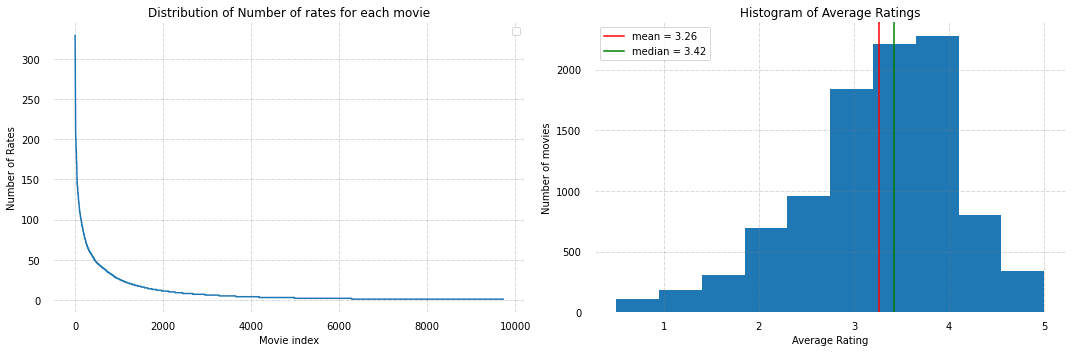

In [15]:
fig, axs = plt.subplots(1, 2,figsize =(15, 5), tight_layout = True)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs[0].spines[s].set_visible(False)
    axs[1].spines[s].set_visible(False)

# Remove x, y ticks
axs[0].xaxis.set_ticks_position('none')
axs[0].yaxis.set_ticks_position('none')
axs[1].xaxis.set_ticks_position('none')
axs[1].yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs[0].xaxis.set_tick_params(pad = 5)
axs[0].yaxis.set_tick_params(pad = 10)
axs[1].xaxis.set_tick_params(pad = 5)
axs[1].yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs[0].grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)
axs[1].grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)

axs[0].plot(np.arange(len(movies_df)), movies_df.sort_values(by=['num_of_rates'], ascending=False)['num_of_rates'].values)
axs[0].set_xlabel('Movie index')
axs[0].set_ylabel('Number of Rates')
axs[0].set_title('Distribution of Number of rates for each movie')
axs[0].legend()

axs[1].hist(np.sort(movies_df['avg_rating'].values), bins = 10)
axs[1].set_xlabel('Average Rating')
axs[1].set_ylabel('Number of movies')
axs[1].set_title('Histogram of Average Ratings')
axs[1].axvline(x = np.mean(movies_df['avg_rating'].values), color = 'r', label = 'mean = {}'.format(round(np.mean(movies_df['avg_rating'].values),2)))
axs[1].axvline(x = np.median(movies_df['avg_rating'].values), color = 'g', label = 'median = {}'.format(round(np.median(movies_df['avg_rating'].values),2)))
axs[1].legend()

### Top 10 movies based on number of votes

For the next step, we show the top 10 movies with the highest number of rates. For this purpose, we need to sort the movies base on the number of rates.

In [16]:
movies_df.sort_values(by=['num_of_rates'], ascending=False)[['movieId','year','title','num_of_rates','avg_rating','genres']].head(10)

,movieId,year,title,num_of_rates,avg_rating,genres
314,356,1994,Forrest Gump (1994),329,4.164134,Comedy|Drama|Romance|War
277,318,1994,"Shawshank Redemption, The (1994)",317,4.429022,Crime|Drama
257,296,1994,Pulp Fiction (1994),307,4.197068,Comedy|Crime|Drama|Thriller
510,593,1991,"Silence of the Lambs, The (1991)",279,4.161290,Crime|Horror|Thriller
1938,2571,1999,"Matrix, The (1999)",278,4.192446,Action|Sci-Fi|Thriller
224,260,1977,Star Wars: Episode IV - A New Hope (1977),251,4.231076,Action|Adventure|Sci-Fi
418,480,1993,Jurassic Park (1993),238,3.750000,Action|Adventure|Sci-Fi|Thriller
97,110,1995,Braveheart (1995),237,4.031646,Action|Drama|War
507,589,1991,Terminator 2: Judgment Day (1991),224,3.970982,Action|Sci-Fi
461,527,1993,Schindler's List (1993),220,4.225000,Drama|War


### Top 10 movies based on average rating

These are the top 10 movies based on the  average rating which were obtained by sorting the movies based on the average rating.

However, the results show us that the average rating is not a proper measure to find the best movies. Because there are large number of movies that has e.g. just one rating which is 5. But since this movie is not watched and rated by many users, it may not be a good movie.

In [17]:
movies_df.sort_values(by=['avg_rating'], ascending=False)[['movieId','year','title','num_of_rates','avg_rating','genres']].head(10)


,movieId,year,title,num_of_rates,avg_rating,genres
7638,88448,2010,Paper Birds (Pájaros de papel) (2010),1,5.0,Comedy|Drama
8089,100556,2012,"Act of Killing, The (2012)",1,5.0,Documentary
9065,143031,2007,Jump In! (2007),1,5.0,Comedy|Drama|Romance
9076,143511,2015,Human (2015),1,5.0,Documentary
9078,143559,2015,L.A. Slasher (2015),1,5.0,Comedy|Crime|Fantasy
4245,6201,1986,Lady Jane (1986),1,5.0,Drama|Romance
8136,102217,1993,Bill Hicks: Revelations (1993),1,5.0,Comedy
8130,102084,1990,Justice League: Doom (2012),1,5.0,Action|Animation|Fantasy
4240,6192,2002,Open Hearts (Elsker dig for evigt) (2002),1,5.0,Romance
9104,145994,1984,Formula of Love (1984),1,5.0,Comedy


### Correlation of average rating and the number of ratings.
We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 3.5_4.

The number of rating distribution shows that most movies have less than 30000-40000 ratings.

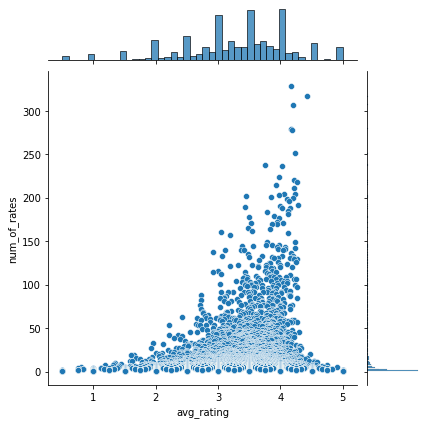

In [18]:
topN_movies = movies_df.sort_values(by=['num_of_rates'] , ascending=False)[:10000]
topN_movies
sns.jointplot(x='avg_rating', y='num_of_rates', data=topN_movies)

### Production of each genre

In [19]:
for g in genres:
    movies_df[g] = 0
    movies_df[g] = movies_df['genres'].apply(lambda x : int(g in x)) #check if the movie belongs to that genre 

movies_df.head()

,movieId,avg_rating,num_of_rates,title,genres,year,Adventure,Animation,Children,Comedy,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,3.920930,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,3.431818,110,Jumanji (1995),Adventure|Children|Fantasy,1995,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3.259615,52,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,2.357143,7,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,3.071429,49,Father of the Bride Part II (1995),Comedy,1995,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Here we will calculate the number of movies in each genre. Then we plot the number of movies in each genre.

To show the relations between the number of movies in each genre better, we plot the pie chart as well.

As we can see, most of the movies have drama genre and on the next level, they are comedy.

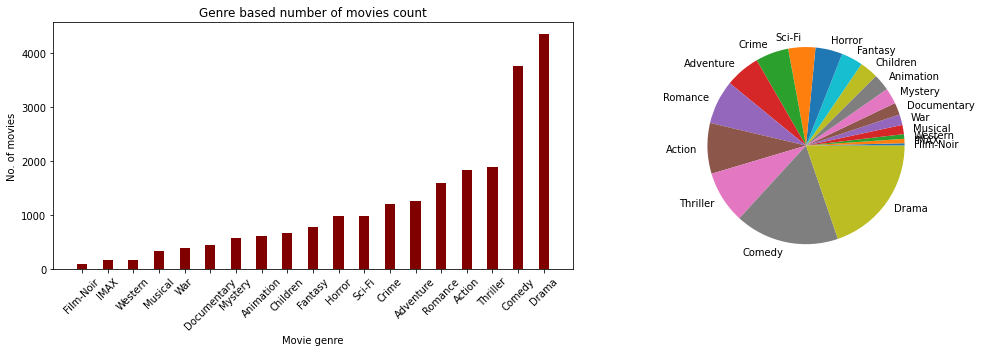

In [20]:
genre_movies = {}
for genre in genres[:-1]:
    genre_movies[genre] = sum(list(movies_df[genre].values))

# sort dict
keys = list(genre_movies.keys())
values = list(genre_movies.values())
sorted_value_index = np.argsort(values)
genre_movies = {keys[i]: values[i] for i in sorted_value_index}

fig, axs = plt.subplots(1, 2,figsize =(15, 5), tight_layout = True)

axs[0].bar(genre_movies.keys(), genre_movies.values(), color ='maroon',width = 0.4)
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].set_xlabel("Movie genre")
axs[0].set_ylabel("No. of movies")
axs[0].set_title('Genre based number of movies count')

axs[1].pie(genre_movies.values(), labels=genre_movies.keys())
axs[1].tick_params(axis='x', labelrotation = 45)

plt.show()

### Production of each genre in years

To understand the number of the movies in each genre in different years, we have to groupby the movie dataset based on the year, then use sum function on each genre.

In [21]:
year_genre_df = movies_df.groupby(by='year')['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'].sum()

year_genre_df = year_genre_df.reset_index()
year_genre_df.head()   

<ipython-input-21-3662e52de14b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_genre_df = movies_df.groupby(by='year')['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',


,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1902,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,1903,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1908,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1915,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1916,1,0,0,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0


The movies produced after 1990

The chart shows the number of movies produced after 1990 in each genre and in each year.

As we can see, the number of produced movies has rised in years and we can see approximately from the chart that drama has the largest number of produced movies which is exactly what we saw in previous sections.

Since the dataset has collected in September 2018, the number of movies in this year is smaller than the other years. 
Also this may be the case that less people have seen the movies produced in 2017 when the data collected, so the number of movies rated by them is not as much as it should be.

In general we can see the number of movies in each year has an increasing behavior.

In [22]:
year_genre_df = year_genre_df[year_genre_df['year'] > 1990]
year_genre_df.head()

,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
78,1991,18,6,7,68,14,30,62,26,17,...,9,10,13,1,7,4,1,2,0,0
79,1992,12,8,13,69,9,36,78,31,23,...,13,5,10,4,5,6,1,3,2,1
80,1993,19,9,17,77,15,33,99,43,20,...,12,12,14,5,4,3,0,3,1,0
81,1994,30,12,24,111,16,41,114,40,27,...,15,8,11,6,3,7,2,7,1,0
82,1995,29,12,29,90,16,49,123,44,33,...,19,18,19,14,4,6,1,6,1,2


Text(0, 0.5, 'Count of Movies')

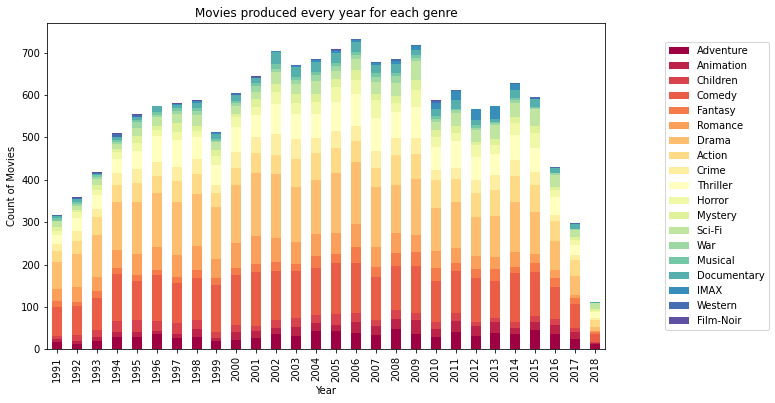

In [23]:
cmap = cm.get_cmap('Spectral', len(genres[:-1]))
ax = year_genre_df.plot.bar(x='year', y = genres[:-1], stacked = True, legend=False, figsize=(10,6) , cmap=cmap,
                       title='Movies produced every year for each genre' )

plt.legend(loc=10, bbox_to_anchor=(1.2, .5), ncol=1)
ax.set_xlabel('Year')
ax.set_ylabel('Count of Movies')

The trend of produced movies in each genre every year after 1990 is shown below. This is the same results we got in the previous section.

And as we expected the comedy has the largest number of movies after drama.

Text(0, 0.5, 'Count of Movies')

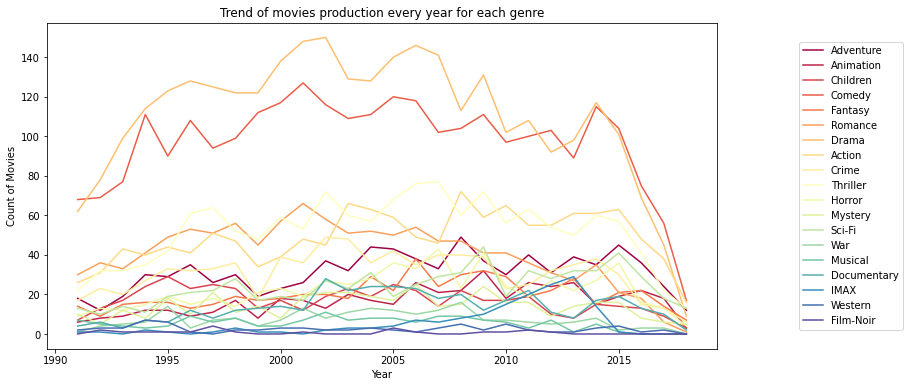

In [24]:
cmap = cm.get_cmap('Spectral')
ax = year_genre_df.plot(x='year', y = genres[:-1], legend=False, figsize=(12,6) , cmap=cmap,
                       title='Trend of movies production every year for each genre' )

plt.legend(loc=10, bbox_to_anchor=(1.2, .5), ncol=1)
ax.set_xlabel('Year')
ax.set_ylabel('Count of Movies')

### Average rating of each genre

For each genre we calculate the average ratings here.

In [25]:
genres_rates = {}

for index, row in movies_df.iterrows():
    genres = row['genres'].split("|")
    num_of_rates = row['num_of_rates']
    avg_rate = row['avg_rating']
    sum_rate = num_of_rates * avg_rate

    for genre in genres:
        if(genre not in genres_rates):
           genres_rates[genre]  = {'avg_rate': sum_rate / num_of_rates , 'numebr_of_rates': num_of_rates}
        else:
           genres_rates[genre]  = {'avg_rate': (sum_rate + genres_rates[genre]['avg_rate']*genres_rates[genre]['numebr_of_rates']) / (num_of_rates + genres_rates[genre]['numebr_of_rates']) , 'numebr_of_rates': num_of_rates + genres_rates[genre]['numebr_of_rates']}

genre_rates_df = pd.DataFrame.from_dict(genres_rates, orient='index')

If we consider the popularity based on the average rates, it can be said that genres below are the five most popular genres:
1. Film-Noir(3.920115)
2. War(3.808294)
3. Documentary(3.797785)
4. Crime(3.658294)
5. Drama(3.656184)

We know that this cannot be the proper measure for popularity of a genre. We can see that the documentary genre has a high average rating, but the voters for it are relatively low. And this shows that the movies of this genre have a small audience, but the audience loved them.

So we can not compare the movies of different genres just based on the average rating. This measure can be useful when we want to compare the movies with the same genre or movies that have the same voters. 

In [26]:
genre_rates_df.sort_values('avg_rate', ascending=False)


,avg_rate,numebr_of_rates
Film-Noir,3.920115,870
War,3.808294,4859
Documentary,3.797785,1219
Crime,3.658294,16681
Drama,3.656184,41928
Mystery,3.632460,7674
Animation,3.629937,6988
IMAX,3.618335,4145
Western,3.583938,1930
Musical,3.563678,4138


### Popularity of generes based on number of rates they have given 

If we sort the genres based on the number of rates, we can see that Drama has the most fans. 

Also it seems that the number of rates can be a good measure to find the popularity of the genres between the users.

In [27]:
genre_rates_df.sort_values('numebr_of_rates', ascending=False)

,avg_rate,numebr_of_rates
Drama,3.656184,41928
Comedy,3.384721,39053
Action,3.447984,30635
Thriller,3.493706,26452
Adventure,3.508609,24161
Romance,3.506511,18124
Sci-Fi,3.455721,17243
Crime,3.658294,16681
Fantasy,3.491001,11834
Children,3.412956,9208


### Genres average rating in years

Here we would like to find the average rating of each genre in each year.

In [28]:
genre_year_rating = {}

for index, row in movies_df.iterrows():
    title = row['title']
    genres = row['genres'].split("|")
    
    for genre in genres:
        genre_year_rating[str(row['movieId']) + '_' + genre] = {'movieId': row['movieId'], 'genre': genre, 'year':row['year'], 'avg_rating':row['avg_rating'], 'num_of_rates': row['num_of_rates']}

genre_year_rating_df = pd.DataFrame.from_dict(genre_year_rating, orient='index')
genre_year_rating_df.reset_index(drop=True, inplace=True) 
genre_year_rating_df['total_rate'] = genre_year_rating_df['avg_rating'] * genre_year_rating_df['num_of_rates'] 
genre_year_rating_df.head()

,movieId,genre,year,avg_rating,num_of_rates,total_rate
0,1,Adventure,1995,3.92093,215,843.0
1,1,Animation,1995,3.92093,215,843.0
2,1,Children,1995,3.92093,215,843.0
3,1,Comedy,1995,3.92093,215,843.0
4,1,Fantasy,1995,3.92093,215,843.0


In [29]:
## Groupby genres and years to find the total score and total users of each genre in each year
df = genre_year_rating_df.groupby(by=['genre', 'year']).agg({'num_of_rates': 'sum', 
                                                        'total_rate': 'sum',
                                                        'movieId': 'count'})
df.reset_index(inplace=True)

## Calculate average rating 
df['avg_rating'] = df['total_rate'] / df['num_of_rates']

## Remove the rows have year less than 1996
df = df[df['year'] > 1995]
df.head()

,genre,year,num_of_rates,total_rate,movieId,avg_rating
7,(no genres listed),1996,1,4.0,1,4.000000
8,(no genres listed),2007,1,5.0,1,5.000000
9,(no genres listed),2013,3,12.0,2,4.000000
10,(no genres listed),2015,6,18.5,3,3.083333
11,(no genres listed),2016,8,22.5,7,2.812500


We plot the average rating of each genre in different years after 1995.
As we can see, the graph shows no significant change in average rating for each genre in years.

However, we understand that the average ratings fluctuates around 3.5.

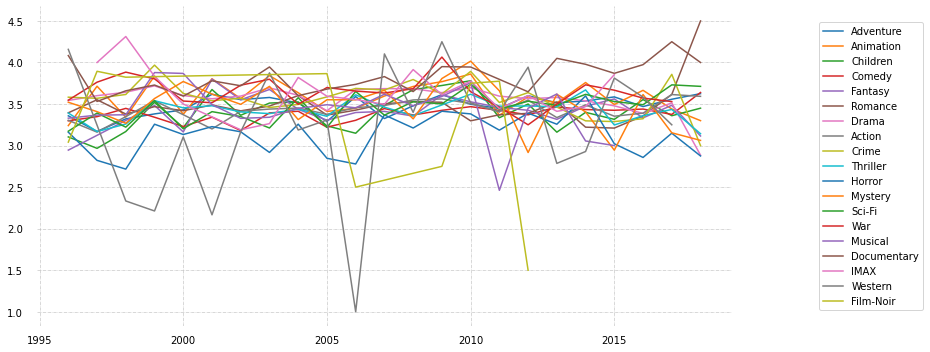

In [30]:
genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)']
       
fig, axs = plt.subplots(1, 1,figsize =(13, 5), tight_layout = True)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

for genre in genres[:-1]:
    axs.plot(df[df['genre'] == genre]['year'], df[df['genre'] == genre]['avg_rating'], label=genre)

plt.legend(loc=10, bbox_to_anchor=(1.2, .5), ncol=1)


### Average number of genres for each movie

Each movie is placed in 1.84 different genres on average with std = 0.98 and the max number of genres for a movie is 10.

In [31]:
df = genre_year_rating_df.groupby(by=['movieId']).agg({'genre': 'count'})
df.describe()

,genre
count,9724.000000
mean,2.267174
std,1.123637
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,10.000000


### Distribition of ratings frequency

Rates 3-4 are the most frequent rates, because movies that get more points are seen more and are given more points.

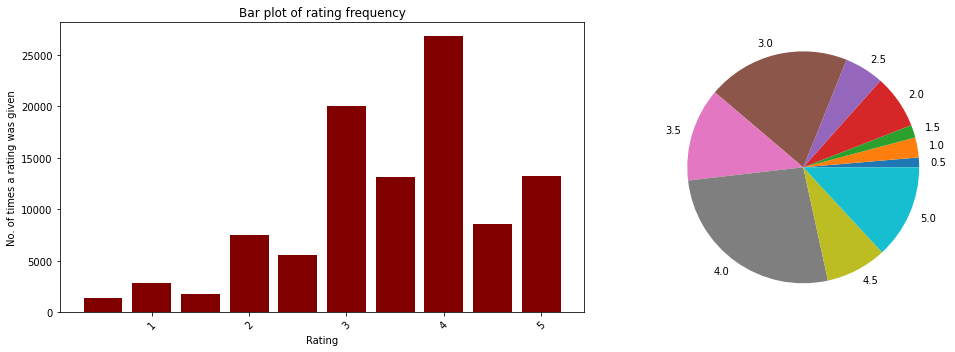

In [32]:
df = ratings_df.groupby(by=['rating']).agg({'userId':'count'})
df.reset_index(inplace=True)

fig, axs = plt.subplots(1, 2,figsize =(15, 5), tight_layout = True)

axs[0].bar(df['rating'].values, df['userId'].values, color ='maroon',width = 0.4)
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("No. of times a rating was given")
axs[0].set_title('Bar plot of rating frequency')

axs[1].pie(df['userId'].values, labels=df['rating'].values)
axs[1].tick_params(axis='x', labelrotation = 45)

plt.show()

### Average number of films rated by each user

In this section we used the groupby function on the rating dataset using the user id and then we counted the number of movie ids that each user rate.

The chart below shows that each user has rated about 98 movies on average. We can see the long-tail phenomenone in the graph of the number of rates for each user.

In [33]:

df = ratings_df.groupby(by=['userId']).agg({'movieId': 'count'})
df.columns = ['movies']
print(df.describe())
df.head()

            movies
count   610.000000
mean    165.304918
std     269.480584
min      20.000000
25%      35.000000
50%      70.500000
75%     168.000000
max    2698.000000


,movies
userId,
1,232
2,29
3,39
4,216
5,44


With the box plot below of the nummber of movies that each user rates, we can see the outliers and we would understand that 0.0003% of users have reated more that 215 movies.

Num of Outliers:  70
Boxes:  [array([ 35.,  35., 168., 168.,  35.])]
Medians:  [array([70.5, 70.5])]
Whiskers:  [array([35., 20.]), array([168., 366.])]


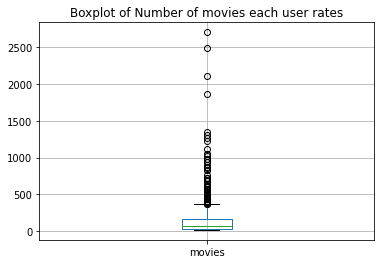

In [34]:
_, bp = pd.DataFrame.boxplot(df, return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

print("Num of Outliers: ", len(outliers[0]))
print("Boxes: ", boxes)
print("Medians: ", medians)
print("Whiskers: ", whiskers)

_.set_title('Boxplot of Number of movies each user rates')
_.set_xlabel('')
plt.show()

In [35]:
len(outliers) / len(df)

0.001639344262295082

The plot below is the distribution of the number of movies each user has rated.
As we can understand from the figure, very few users rated to lots of movies.

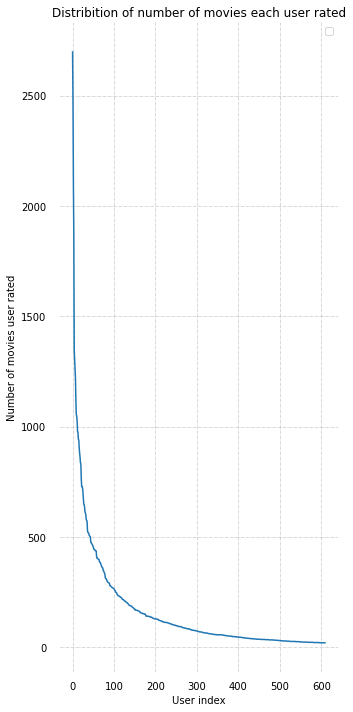

In [36]:
fig, axs = plt.subplots(1, 1,figsize =(5, 10), tight_layout = True)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

# histogram
# axs.hist(np.sort(df['movies'].values), bins = 200)
# axs.set_title('Histogram of Number of Movies the Users Rated')
# axs.set_xlabel('Number of Movies')
# axs.set_ylabel('Number of Users')
# axs.axvline(x = np.mean(df['movies'].values), color = 'r', label = 'mean = {}'.format(round(np.mean(df['movies'].values),2)))
# axs.axvline(x = np.median(df['movies'].values), color = 'g', label = 'median = {}'.format(round(np.median(df['movies'].values),2)))

axs.plot(np.arange(len(df)), df.sort_values('movies', ascending=False))
axs.set_title('Distribition of number of movies each user rated')
axs.set_xlabel('User index')
axs.set_ylabel('Number of movies user rated')
axs.legend()

### Average number of tags for each movie

Now we want to work with the tag data set. First we calculate the average number of tags for each movie.

Then we have the boxplot of the number of tags for movies.



In [37]:
movie_tag_df = tags_df.groupby(by=['movieId']).agg({'tag':'count'})
movie_tag_df.describe()

,tag
count,1572.000000
mean,2.342875
std,5.562342
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,181.000000


Num of Outliers:  225
Boxes:  [array([1., 1., 2., 2., 1.])]
Medians:  [array([1., 1.])]
Whiskers:  [array([1., 1.]), array([2., 3.])]


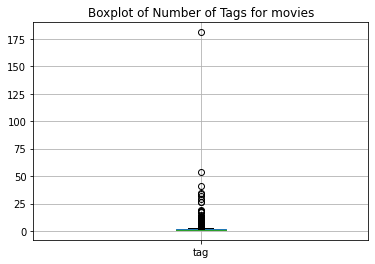

In [38]:
_, bp = pd.DataFrame.boxplot(movie_tag_df, return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

print("Num of Outliers: ", len(outliers[0]))
print("Boxes: ", boxes)
print("Medians: ", medians)
print("Whiskers: ", whiskers)

_.set_title('Boxplot of Number of Tags for movies')
_.set_xlabel('')
plt.show()

Also here we see that very little number of movies has lots of tags.

Text(0.5, 1.0, 'Distribution of number of tags for movies')

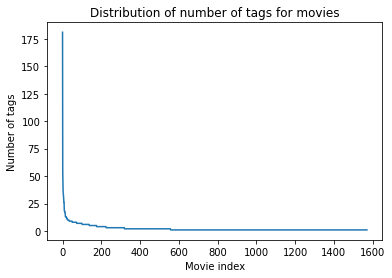

In [39]:
plt.plot(np.arange(len(movie_tag_df)), movie_tag_df.sort_values('tag',ascending=False)['tag'].values)
plt.xlabel('Movie index')
plt.ylabel('Number of tags')
plt.title('Distribution of number of tags for movies')

### Top 10 movies with the most tags

For this first we have to sort the tags and obtain the top 10 of them, then we merge it with the movie dataset to find the to 10 movies with the most tags.

In [40]:
top10_movies_tag_df = movie_tag_df.sort_values('tag', ascending=False).head(10)
cols = list(movies_df.columns[:6])
cols.extend(list(movie_tag_df.columns))
pd.merge(top10_movies_tag_df, movies_df , on='movieId')[cols]

,movieId,avg_rating,num_of_rates,title,genres,year,tag
0,296,4.197068,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,181
1,2959,4.272936,218,Fight Club (1999),Action|Crime|Drama|Thriller,1999,54
2,924,3.894495,109,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,1968,41
3,293,4.018797,133,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller,1994,35
4,7361,4.160305,131,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004,34
5,1732,3.924528,106,"Big Lebowski, The (1998)",Comedy|Crime,1998,32
6,4878,3.981651,109,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller,2001,29
7,79132,4.066434,143,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,2010,26
8,260,4.231076,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1977,26
9,135536,2.916667,12,Suicide Squad (2016),Action|Crime|Sci-Fi,2016,19


### Average number of tags each user tagged

In [41]:
user_tag_df = tags_df.groupby(by=['userId']).agg({'tag':'count'})
user_tag_df.describe()

,tag
count,58.000000
mean,63.500000
std,215.118103
min,1.000000
25%,2.250000
50%,4.000000
75%,13.000000
max,1507.000000


Text(0.5, 1.0, "Distribution of number of user's tags")

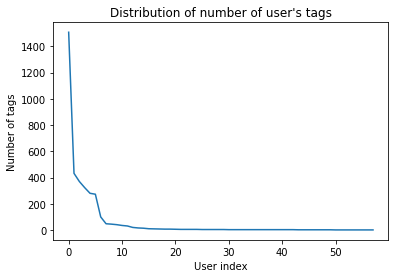

In [42]:
plt.plot(np.arange(len(user_tag_df)), user_tag_df.sort_values('tag',ascending=False)['tag'].values)
plt.xlabel('User index')
plt.ylabel('Number of tags')
plt.title("Distribution of number of user's tags")

# Collaborative Filtering

Problem formulation: 
To build a recommender system that recommends movies based on Collaborative-Filtering techniques using the power of other users.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Now, our ratings dataframe is indexed by user ids with movie ids belonging to different columns and the values are the ratings with most of the values as Nan as each user watches and rates only few movies. Its a sparse dataframe.

Since the full data set is very large, it cannot create the matrix.

In [44]:
# Create user-item matrix
matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')
matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We Normalized the data.

In [45]:
# Data Normalization 
normalized_matrix = matrix.apply(lambda x : x - np.mean(x), axis=1)
normalized_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,NaN,-0.366379,NaN,NaN,-0.366379,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then we wanted to find the similar users using the cosine similarity. So we created the user_simikarity data set which you can see below.

In [46]:
# Find Similar Users
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(normalized_matrix.fillna(0))
user_similarity = pd.DataFrame(user_similarity_cosine)
user_similarity


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.008754,...,0.018127,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
1,0.001265,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003012,...,-0.050551,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
2,0.000553,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
3,0.048419,-0.017164,-0.011260,1.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.051590,...,-0.037687,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
4,0.021847,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010117,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.012016,0.006226,-0.037289,0.020590,0.026319,-0.009137,0.028326,0.022277,0.031633,-0.039946,...,0.053683,0.016384,0.098011,0.061078,0.019678,1.000000,0.017927,0.056676,0.038422,0.075464
606,0.055261,-0.020504,-0.007789,0.014628,0.031896,0.045501,0.030981,0.048822,-0.012161,-0.017656,...,0.049059,0.038197,0.049317,0.002355,-0.029381,0.017927,1.000000,0.044514,0.019049,0.021860
607,0.075224,-0.006001,-0.013001,-0.037569,-0.001751,0.021727,0.028414,0.071759,0.032783,-0.052000,...,0.069198,0.051388,0.012801,0.006319,-0.007978,0.056676,0.044514,1.000000,0.050714,0.054454
608,-0.025713,-0.060091,0.000000,-0.017884,0.093829,0.053017,0.008754,0.077180,0.000000,-0.040090,...,0.043465,0.062400,0.015334,0.094038,-0.054722,0.038422,0.019049,0.050714,1.000000,-0.012471


## N-most similar users 

To find the n-most silimar users, first we picked one user id (e.g. 1) and found the top 10 most similar users to user_id 1 by sorting the user similarity matrix and droping the rest.

In [47]:
# Pick a user ID
picked_userid = 1
# Number of similar users
n = 10
topN_similar_users = user_similarity.drop(index=picked_userid)[picked_userid].sort_values(ascending=False)[:n]
topN_similar_users

188    0.134677
245    0.106334
377    0.099583
208    0.089539
226    0.085428
325    0.079273
392    0.063399
331    0.062821
195    0.050699
527    0.048683
Name: 1, dtype: float64

Then we have to remove all the movies that non of the similar users have watched. All NaN columns are useless, so we removed them.

In [48]:
similar_user_movies = normalized_matrix[normalized_matrix.index.isin(topN_similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

movieId,1,2,3,6,7,10,16,19,22,25,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
userId,,,,,,,,,,,,,,,,,,,,,
188,NaN,NaN,NaN,NaN,-0.395833,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,NaN,NaN,NaN,0.470588,NaN,0.470588,0.470588,NaN,NaN,0.470588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,NaN,NaN,NaN,NaN,NaN,-1.307692,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,0.023669,-0.476331,0.023669,NaN,NaN,0.523669,1.023669,0.023669,-1.476331,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,NaN,NaN,NaN,0.455556,NaN,NaN,NaN,-1.544444,-0.544444,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,-0.627976,NaN,NaN,NaN,NaN,...,0.372024,-0.127976,1.372024,1.372024,0.372024,-1.127976,0.372024,0.372024,0.372024,0.372024
377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.912214,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Then we removed the movies that the target user wathed from the list of movies have seen by similar users.

In [49]:
picked_userid_watched = normalized_matrix[normalized_matrix.index == picked_userid].dropna(axis=1, how='all') # Movies that the target user has watched
similar_user_movies.drop(picked_userid_watched.columns, inplace=True, axis=1, errors='ignore')
similar_user_movies

movieId,2,7,10,16,19,22,25,29,30,32,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
userId,,,,,,,,,,,,,,,,,,,,,
188,NaN,-0.395833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,NaN,NaN,0.470588,0.470588,NaN,NaN,0.470588,NaN,NaN,0.470588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,NaN,NaN,-1.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,-0.476331,NaN,0.523669,1.023669,0.023669,-1.476331,NaN,NaN,NaN,0.523669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,NaN,NaN,NaN,NaN,-1.544444,-0.544444,NaN,0.455556,0.455556,0.455556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,-0.627976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.372024,-0.127976,1.372024,1.372024,0.372024,-1.127976,0.372024,0.372024,0.372024,0.372024
377,NaN,NaN,NaN,NaN,-1.912214,NaN,NaN,NaN,NaN,0.587786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Find the number of movies wathced in each column.
# It's used to calculate the average after dot product
number_of_items_not_nan = n - similar_user_movies.isna().sum()
number_of_items_not_nan = pd.DataFrame(number_of_items_not_nan).swapaxes("index", "columns").reset_index(drop=True)
number_of_items_not_nan

movieId,2,7,10,16,19,22,25,29,30,32,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
0,2,1,4,2,3,2,1,1,2,4,...,1,1,1,1,1,1,1,1,1,1


In [51]:
# Sort similar users based on their id. 
# Because the matrix is sorted by id and for dot product we need to have aligned matrices.
topN_similar_users_df = pd.DataFrame(topN_similar_users).sort_index()
topN_similar_users_df = topN_similar_users_df.swapaxes("index", "columns").reset_index(drop=True)
topN_similar_users_df

,188,195,208,226,245,325,331,377,392,527
0,0.134677,0.050699,0.089539,0.085428,0.106334,0.079273,0.062821,0.099583,0.063399,0.048683


In [52]:
# Fillna the nan values to caculate weighted sum
similar_user_movies = similar_user_movies.fillna(0)
similar_user_movies

movieId,2,7,10,16,19,22,25,29,30,32,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
userId,,,,,,,,,,,,,,,,,,,,,
188,0.000000,-0.395833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
195,0.000000,0.000000,0.470588,0.470588,0.000000,0.000000,0.470588,0.000000,0.000000,0.470588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
208,0.000000,0.000000,-1.307692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
226,-0.476331,0.000000,0.523669,1.023669,0.023669,-1.476331,0.000000,0.000000,0.000000,0.523669,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
325,0.000000,0.000000,0.000000,0.000000,-1.544444,-0.544444,0.000000,0.455556,0.455556,0.455556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
331,0.000000,0.000000,-0.627976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.372024,-0.127976,1.372024,1.372024,0.372024,-1.127976,0.372024,0.372024,0.372024,0.372024
377,0.000000,0.000000,0.000000,0.000000,-1.912214,0.000000,0.000000,0.000000,0.000000,0.587786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
weighted_sum = topN_similar_users_df.dot(similar_user_movies)
weighted_sum

movieId,2,7,10,16,19,22,25,29,30,32,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
0,-0.046522,-0.05331,-0.087945,0.111309,-0.310834,-0.16928,0.023858,0.036113,-0.115765,0.163241,...,0.023371,-0.00804,0.086192,0.086192,0.023371,-0.070861,0.023371,0.023371,0.023371,0.023371


In [54]:
average_weighted = weighted_sum.div(number_of_items_not_nan)
average_weighted

movieId,2,7,10,16,19,22,25,29,30,32,...,116797,119145,122882,122904,134130,164179,177765,183897,187593,193609
0,-0.023261,-0.05331,-0.021986,0.055654,-0.103611,-0.08464,0.023858,0.036113,-0.057882,0.04081,...,0.023371,-0.00804,0.086192,0.086192,0.023371,-0.070861,0.023371,0.023371,0.023371,0.023371


By selecting the top m=10 movies from the average weighted, we achieve the goal of this section.

In [55]:
# Select top m movies
m = 10
recommended_movies = average_weighted.swapaxes("index", "columns").nlargest(m, [0]).index.values
recommended_movies

array([ 246, 1189,  170,  180,  671, 3653, 5110, 6188,  194,  541])

## All users
Here, we don't pick the top 10 most similar user and then find the recommendations based on them. Because sometimes the users that are not close to the target user might have effect on the recommended movies. For example if user 1 is not close to user 2 and user 2 like the movie 20, then it is probable that user 1 doesn't like the movie 20 at all. Thus we use all users here and will use the average weighting for the recommendation.

First we normalize the matrix.

In [56]:
normalized_matrix = matrix.apply(lambda x : x - np.mean(x), axis=1)
number_of_items_not_nan = normalized_matrix.shape[0] - normalized_matrix.isna().sum()
number_of_items_not_nan.shape

(9724,)

Then we change the diagonal values of the user_user similarity matrix to 0 since it doesn't make sense to use our own recommendations for ourselves.

In [57]:
# Zero the diagonal values for user_user similarity 
user_similarity_cosine = cosine_similarity(normalized_matrix.fillna(0))
np.fill_diagonal(user_similarity_cosine, 0)
user_similarity_cosine

array([[ 0.        ,  0.00126452,  0.00055258, ...,  0.07522385,
        -0.02571255,  0.01093232],
       [ 0.00126452,  0.        ,  0.        , ..., -0.00600083,
        -0.060091  ,  0.02499921],
       [ 0.00055258,  0.        ,  0.        , ..., -0.01300064,
         0.        ,  0.01954996],
       ...,
       [ 0.07522385, -0.00600083, -0.01300064, ...,  0.        ,
         0.05071449,  0.05445388],
       [-0.02571255, -0.060091  ,  0.        , ...,  0.05071449,
         0.        , -0.01247143],
       [ 0.01093232,  0.02499921,  0.01954996, ...,  0.05445388,
        -0.01247143,  0.        ]])

In [58]:
# Each row is for a user and each col represents the weighted sum of user_similarity * movie normalized rating
normalized_matrix = normalized_matrix.fillna(0)
user_predicted_ratings = np.dot(user_similarity_cosine, normalized_matrix)
user_predicted_ratings.shape

(610, 9724)

In [59]:
# Calculate weighted average
wighted_average = np.divide(user_predicted_ratings, np.array(number_of_items_not_nan).reshape(1,len(number_of_items_not_nan)))
wighted_average.shape

(610, 9724)

In [60]:
# Remove items have been watched by user
dummy_train = ratings_df.copy()
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_train = dummy_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(1)

user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,-1.015433,-0.000000,-0.077843,-0.518720,0.000000,-0.583570,-0.166808,-0.120917,-0.273586,...,0.000178,0.000612,-0.000256,-0.000256,0.000178,-0.000256,0.000178,0.000178,0.000178,0.000790
2,-0.312622,-0.171164,-0.107067,0.077337,0.192856,-0.395780,-0.027761,0.060797,0.074661,0.453205,...,-0.003223,-0.011074,0.004629,0.004629,-0.003223,0.004629,-0.003223,-0.003223,-0.003223,-0.015946
3,-0.403507,0.200223,0.010087,0.102880,0.256095,-0.193011,0.155203,0.051953,0.017050,0.395760,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.687272,0.019838,-0.174377,-0.082557,-0.123721,0.077671,-0.362435,-0.053542,-0.099735,-0.152146,...,0.001821,0.006258,-0.002616,-0.002616,0.001821,-0.002616,0.001821,0.001821,0.001821,0.001076
5,0.000000,-0.221264,-0.117955,-0.208953,-0.439558,1.135345,-0.039492,-0.048016,-0.365376,-0.728757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000134


In [61]:
# Top m movies 
picked_user_id = 1
m = 10
user_final_ratings.iloc[picked_user_id].sort_values(ascending = False)[0:m]

movieId
344    1.194383
435    0.951664
153    0.861921
434    0.832188
208    0.804935
231    0.771896
410    0.754490
367    0.721427
44     0.690423
19     0.676169
Name: 2, dtype: float64

# 4. Evaluation

Create the matrix of the whole data

In [62]:
matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')
matrix.shape

(610, 9724)

Here we want to create the matrix of the train data.

To split the data into train and test data fairly, for each user we sampled 80% of the movies they have rated.
To do this, we first used the groupby function on user id and then we assigned the 80% of the data to train set and the rest to the test set.

In [63]:
train_df = ratings_df.groupby('userId', group_keys=False).apply(lambda x: x.sample(frac=0.8))
train_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')
train_matrix.shape

(610, 9003)

However, within this process, the train matrix could be small and doesn't have some of the movies. So we calculated the difference between the columns of the two matrices.

In [64]:
diff = matrix.columns.difference(train_matrix.columns)
diff.shape

(721,)

In [65]:
# Create temp matrix to have the same size of train matrix
temp_matrix = matrix.drop(diff, axis=1, errors='ignore')
temp_matrix.shape

(610, 9003)

Here in order to make the train and the test matrices have the same size, we added 0s and created the test matrix and recompute the train matrix.

In [66]:
# Calculate the test matrix 
test_matrix = temp_matrix.fillna(0) - train_matrix.fillna(0)
test_matrix = test_matrix.join(matrix.fillna(0)[diff])

test_matrix.shape

(610, 9724)

In [67]:
test_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,183199,184053,184245,184349,184641,189381,189547,190209,190213,193583
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Recompute train matrix
train_matrix = matrix.fillna(0) - test_matrix
train_matrix.shape

(610, 9724)

In [69]:
dummy_test = test_matrix.apply(lambda x: 1 if x > 0 else 0, axis=1)
dummy_test

ValueError: ignored

In [70]:
# Make a copy of train and test datasets
dummy_train = X_train.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x > 0 else 0)

# The movies not rated by user is marked as 0 for evaluation 
dummy_test = dummy_test.pivot(index ='userId', columns = 'movieId', values = 'rating').fillna(0)

NameError: ignored

In [71]:
train_matrix.isna().sum()

movieId
1         0
2         0
3         0
4         0
5         0
         ..
193581    0
193583    0
193585    0
193587    0
193609    0
Length: 9724, dtype: int64

We went the steps below to find the predictive value for the watched movie

In [72]:
# Normalized matrix
normalized_matrix = train_matrix.apply(lambda x : x - np.mean(x), axis=1)

# Calculate none NaN for each movie => number of users watched a movie
number_of_items_not_nan = normalized_matrix.shape[0] - normalized_matrix.isna().sum()

# Calculate the cosine similarity 
user_similarity_cosine = cosine_similarity(normalized_matrix.fillna(0))

# Zero simalarity of user with himself
np.fill_diagonal(user_similarity_cosine, 0)

# Dot product of similarity matrix and rating matrix
user_predicted_ratings = np.dot(user_similarity_cosine, normalized_matrix.fillna(0))

# Calculate weighted average
wighted_average = np.divide(user_predicted_ratings, np.array(number_of_items_not_nan).reshape(1,len(number_of_items_not_nan)))

# Add predicted values by user average rating
user_average_rating = np.array(ratings_df.groupby(by=['userId']).agg({'rating':'mean'}).reset_index(drop=True).rating.values).reshape(len(user_average_rating),1) 
prediction = wighted_average + user_average_rating

# Find the predicted value for watched movie
test_user_final_rating = np.multiply(prediction, dummy_test) 

test_user_final_rating

NameError: ignored

In [73]:
dummy_test.shape

NameError: ignored

In [74]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[1],[4]])
a + b
a.shape, b.shape

((2, 3), (2, 1))